## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = plt.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


## And so on and so forth...

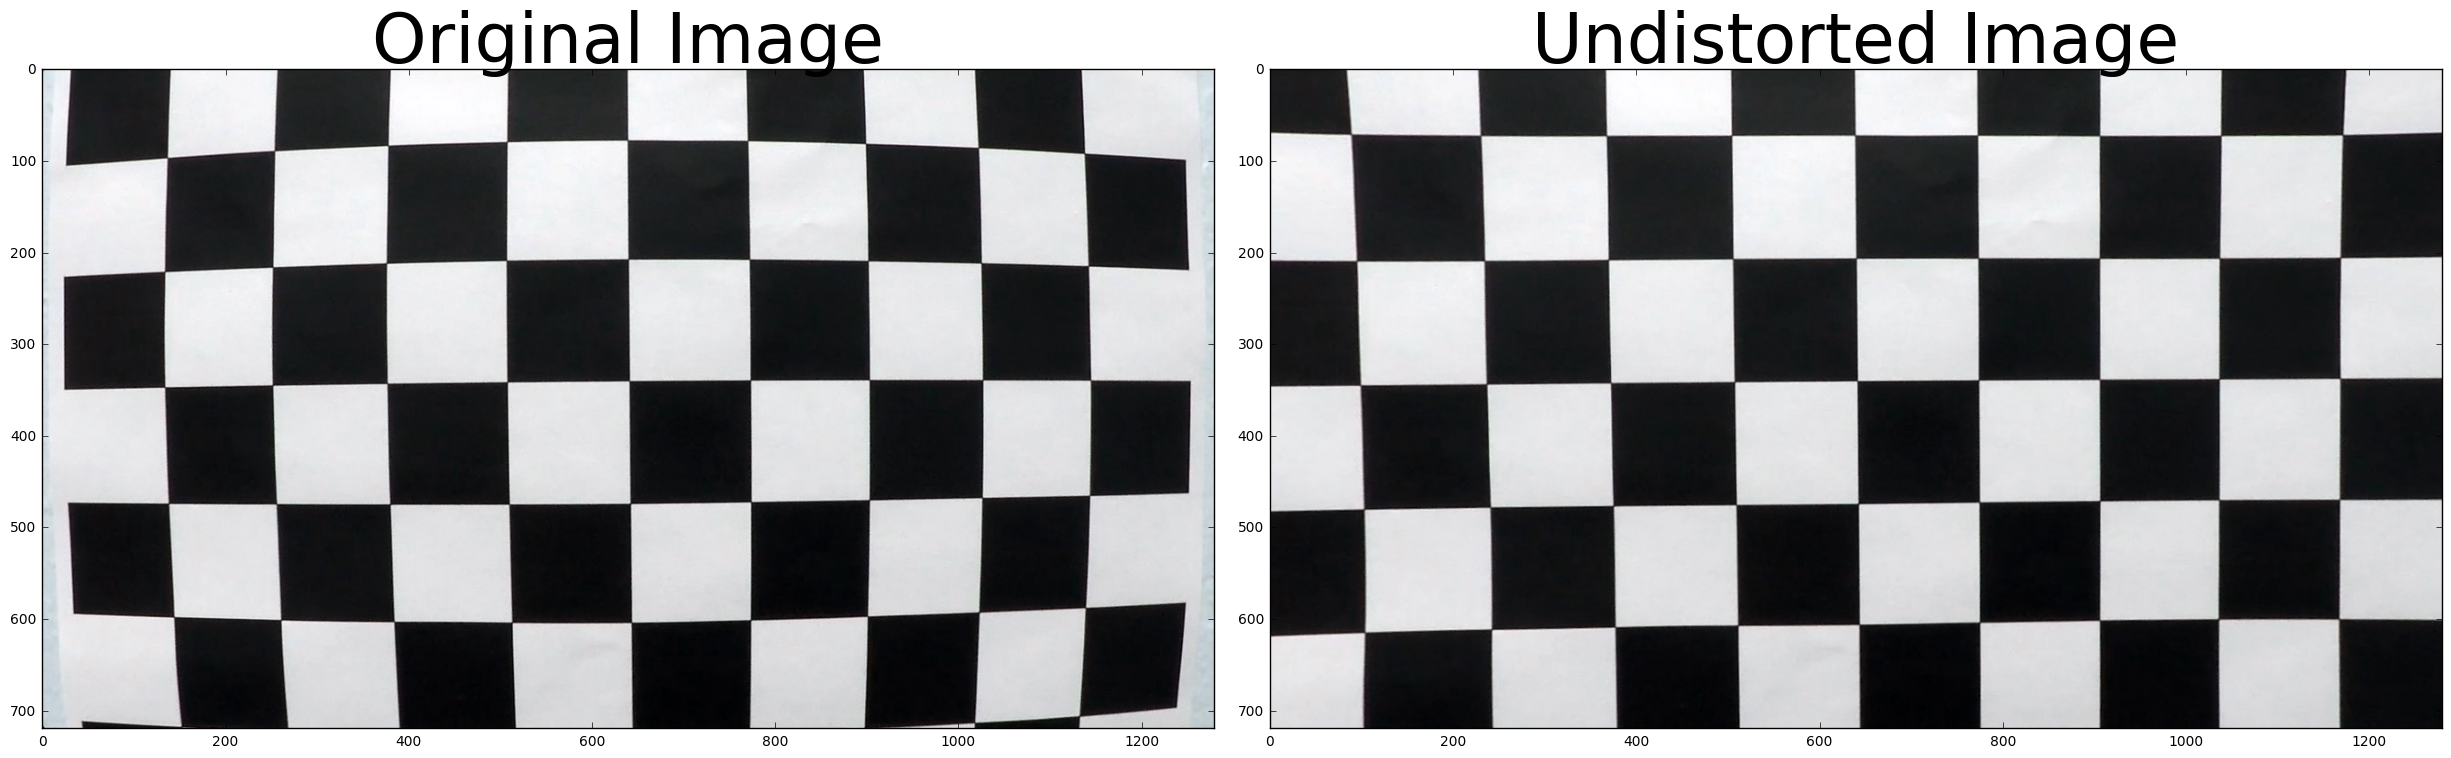

In [68]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def cam_calibration(img,objpts,imgpts):
    return cv2.calibrateCamera(objpts, imgpts, np.shape(img)[0:2], None, None)
def cal_undistort(img, mtx,dist):
    # Use cv2.calibrateCamera and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist
# Read in an image
img = cv2.imread(images[0])

# Calibrate the camera



# function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

ret, mtx, dist, rvecs, tvecs = cam_calibration(img,objpoints,imgpoints)
undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

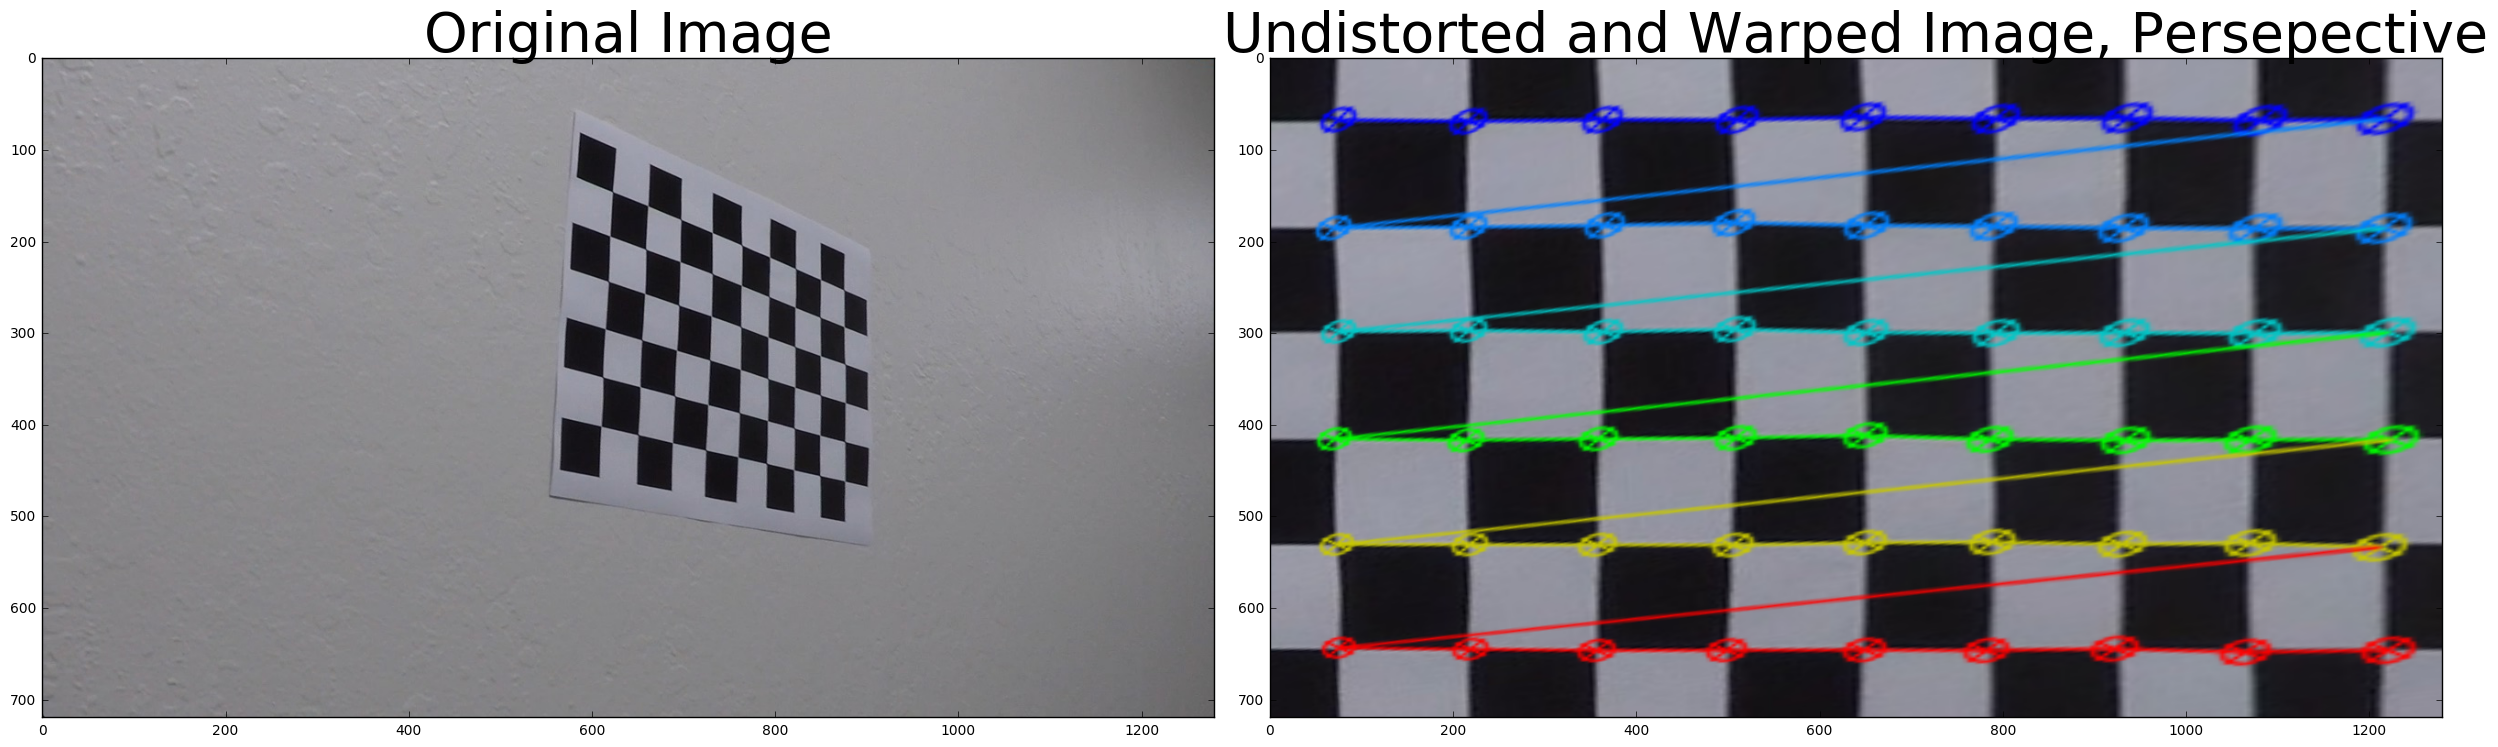

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()

# Read in an image
img = plt.imread(images[-1])
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def cam_calibration(img,objpts,imgpts):
    return cv2.calibrateCamera(objpts, imgpts, np.shape(img)[0:2], None, None)


class Warper():
    def __init__(self,nx,ny,mtx,dist,src,dst):
        self.nx = nx
        self.ny = ny
        self.mtx = mtx
        self.dist = dist
        self.prespective_M = cv2.getPerspectiveTransform(src,dst)
        self.inverse_perseptective_M = cv2.getPerspectiveTransform(dst,src)
        
    def prespective_matrix(self):
        return self.prespective_M
    def inverse_perspective_matrix(self):
        return self.inverse_perspective_matrix
    
    def _cal_undistort(self,img):
        # Use cv2.calibrateCamera and cv2.undistort()
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        #undist = np.copy(img)  # Delete this line
        return undist
    def update_perspective(self,src,dst):
        self.prespective_M = cv2.getPerspectiveTransform(src,dst)
        self.inverse_perseptective_M = cv2.getPerspectiveTransform(dst,src)
    
    def wrap(self,img):
        # 1) Undistort using mtx and dist
        undist_img = self._cal_undistort(img)

        # 2) Convert to grayscale
        gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
        # 3) Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
        if(ret):
            # a) draw corners
            undist_img_draw = cv2.drawChessboardCorners(undist_img, (self.nx, self.ny), corners, ret)

            img_size = np.shape(undist_img_draw)[0:2]
            im_s = (img_size[1],img_size[0])
            warped = cv2.warpPerspective(undist_img_draw
                                         ,self.prespective_M
                                         ,im_s
                                         ,flags=cv2.INTER_LINEAR)
            return warped
        
margin = margin = 75.0
#Generic corner identification
src = np.float32( [
        [corners[nx-1][0][0]     , corners[nx-1][0][1]     ],
        [corners[nx*ny-1][0][0]  , corners[nx*ny-1][0][1]  ],
        [corners[nx*ny-nx][0][0] , corners[nx*ny-nx][0][1] ],
        [corners[0][0][0]        , corners[0][0][1]        ]
        ]  )  
width = img.shape[1]
height = img.shape[0]
dst = np.float32([  
    [width-margin,    margin        ],
    [width-margin ,   height-margin ],
    [margin       ,   height-margin ],
    [margin       ,   margin        ]


         ])
ret, mtx, dist, rvecs, tvecs = cam_calibration(img,objpoints,imgpoints)
wpr = Warper(nx,ny,mtx,dist,src,dst)
top_down = wpr.wrap(img)

#top_down, perspective_M = corners_unwarp(img, nx, ny,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image, Persepective', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [5]:

def pipeline(img, s_thresh=(20, 100), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    l_channel = hsv[:,:,0]
    s_channel = hsv[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_img = hls_img[:,:,2]
    binary_output = np.zeros_like(s_img)
    # 3) Return a binary image of threshold result
    binary_output[(s_img>thresh[0]) & (s_img<=thresh[1])]=1
    #binary_output = np.copy(img) # placeholder line
    return binary_output

def get_hist(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    return histogram
prev_leftx = []
prev_rightx = []
prev_lefty = []
prev_righty = []
def poly_fit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
    #     cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    #     cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    #     print(lefty)
    global prev_rightx
    global prev_leftx
    global prev_righty
    global prev_lefty
    if(len(leftx)) == 0:
        leftx = prev_leftx
        lefty = prev_lefty
    else:
        prev_leftx = leftx
        prev_lefty = lefty 
    if(len(rightx)) == 0:
        rightx = prev_rightx
        righty = prev_righty
    else:
        prev_rightx = rightx
        prev_righty = righty
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    

   

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return out_img,left_fit,right_fit

def highlight(img):
    hsvimg = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20, 120, 120])
    upper_yellow = np.array([30, 255, 255])

    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 255, 255])

    #0, 0, 200
    #180, 255, 255
    # Threshold the HSV image to get only yellow colors
    maskhsv = cv2.inRange(hsvimg, lower_yellow, upper_yellow)
    maskwhite_hsv = cv2.inRange(hsvimg,lower_white,upper_white)

    # Bitwise-AND mask and original image
    res_yellow = cv2.bitwise_and(img,img, mask= maskhsv)
    res_white = cv2.bitwise_and(img,img, mask= maskwhite_hsv)
    res = cv2.bitwise_or(res_yellow,res_white)
    return res

In [6]:
from os import listdir
from os.path import isfile, join

def process_image(img):
#     print(np.shape(img))
    fi, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(24, 9),sharex=True)
    fi.tight_layout()
    img = cal_undistort(img,mtx,dist)
    img_size = np.shape(img)[0:2]
    M = cv2.getPerspectiveTransform(src,dst)
    im_s = (img_size[1],img_size[0])
    for_hsv_img = cv2.warpPerspective(img,M,im_s, flags=cv2.INTER_LINEAR)
    
    ax1.imshow(for_hsv_img)
    
    M_inverse = cv2.getPerspectiveTransform(dst,src)
    
    #hls_img = #hls_select(highlight(img), thresh=(10, 255))
    #hls_img = hls_select(highlight(img),thresh=(80,255))
    hls_img = highlight(img)
    warped = cv2.warpPerspective(hls_img,M,im_s, flags=cv2.INTER_LINEAR)
    histogram = get_hist(warped)
    ax2.plot(histogram)
    
    ax3.imshow(warped,cmap="gray")
    
    out_img2,left_fit,right_fit = poly_fit(warped)    
    #choose the best polyfit 
#     lef = histogram[:len(histogram)/2]
#     rig = histogram[len(histogram)/2:]
#     if(np.std(lef) > np.std(rig)):
#         c = right_fit[2]
#         right_fit = np.copy(left_fit)
#         right_fit[2] = c
#     else:
#         c = left_fit[2]
#         left_fit = np.copy(right_fit)
#         left_fit[2] = c
#     pl = np.zeros_like(warped)
    
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ax4.imshow(out_img2)
#     points = []
#     for i,j in zip(left_fitx,ploty):
#         points.append([i,j])
#     plt.imshow(cv2.polylines(for_hsv_img,np.int32([points]), 2, (0,255,255)))
#     points = []
#     for i,j in zip(right_fitx,ploty):
#         points.append([i,j])
#     plt.imshow(cv2.polylines(for_hsv_img,np.int32([points]), 2, (0,255,255)))
        
    ax4.plot(left_fitx, ploty, color='yellow')
    ax4.plot(right_fitx, ploty, color='yellow')
    plt.show()
#     out_inverse = cv2.warpPerspective(ax4.plot(),M_inverse,im_s, flags=cv2.INTER_LINEAR)
#     plt.imshow(out_inverse)
#     ax4.xlim(0, 1280)
#     ax4.ylim(720, 0)
    fi.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.fromstring(fi.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    result = data.reshape(fi.canvas.get_width_height()[::-1] + (3,))
    return result
class Line():
    def __init__(self,l,r):
        self.left =self.prev_left= l
        self.right =self.prev_right= r
    def update_prev(self,l,r):
        
        self.left = 0.05*self.left + 0.95 * self.prev_left
        self.right = 0.05*self.right + 0.95 * self.prev_right
        self.prev_right = r
        self.prev_left = l
        
new_line = None

def process_image_final(img):
    image = img
#     gradx = abs_sobel_thresh(image, orient='x', thresh = [10,250])
#     mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(100, 200))
#     dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(np.pi/1, np.pi/2))
#     combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     print(np.shape(img))
    image = cal_undistort(image,mtx,dist)
    
    
    img_size = np.shape(img)[0:2]
    M = cv2.getPerspectiveTransform(src,dst)
    im_s = (img_size[1],img_size[0])
    for_hsv_img = cv2.warpPerspective(image,M,im_s, flags=cv2.INTER_LINEAR)
    
    
    M_inverse = cv2.getPerspectiveTransform(dst,src)
    
    hls_img = hls_select(highlight(image), thresh=(10, 255))
#     filtered = combined
#     hls_img = combined #hls_select(filtered,thresh=(100,255))
    
    warped = cv2.warpPerspective(hls_img,M,im_s, flags=cv2.INTER_LINEAR)
    histogram = get_hist(warped)
    
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    out_img2,left_fit,right_fit = poly_fit(warped)  
        #choose the best polyfit 
    lef = histogram[:len(histogram)/2]
    rig = histogram[len(histogram)/2:]
    if(np.std(lef) > np.std(rig)):
        c = right_fit[2]
        m = right_fit[1]
        right_fit = np.copy(left_fit)
        right_fit[2] = c
        right_fit[1] = m
    else:
        c = left_fit[2]
        m= left_fit[1]
        left_fit = np.copy(right_fit)
        left_fit[2] = c
        left_fit[1] = m
    pl = np.zeros_like(warped)
    
    global new_line
    if(new_line == None):
        new_line = Line(left_fit,right_fit)
        new_line.update_prev(left_fit,right_fit)
    else:
        new_line.update_prev(left_fit,right_fit)
    right_fix = new_line.right
    left_fix = new_line.left
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    window_img = np.zeros_like(out_img2)
    
     # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx -margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
#     plt.imshow(cv2.warpPerspective(for_hsv_img,M_inverse,im_s, flags=cv2.INTER_LINEAR))
#     plt.show()

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    window_img_warp = cv2.warpPerspective(window_img,M_inverse,im_s, flags=cv2.INTER_LINEAR)
#     print(np.shape(img))
#     print(np.shape(window_img_warp))
    result = cv2.addWeighted(image, 1, window_img_warp, 0.3, 0)
    
    new_war = np.dstack((warped, warped, warped))*255
    #result = 
    stacked = np.hstack((image,result))
    
    return stacked
    

src = np.float32([
    [585.0, 460.0],
    [203.0, 720.0],
    [1127, 720],
    [695, 460]
])

dst = np.float32([
    [270, 50],
    [270, 670 ],
    [910, 670 ],
    [910, 50 ]
])

from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip1 = VideoFileClip("./Second.mp4")

white_clip = clip1.fl_image(process_image_final)

# onlyfiles = glob.glob("../test_images/*.jpg")
# for each in onlyfiles:
#     image = plt.imread(each)
#     plt.imshow(process_image_final(image))
#     plt.show()

    

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

In [7]:
# Change perspective
# HSL on the HSV highlighted image
# Poly fit
# change perspective back

In [8]:
white_output="./first.mp4"
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./first.mp4
[MoviePy] Writing video ./first.mp4


100%|█████████▉| 720/721 [02:26<00:00,  4.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./first.mp4 

CPU times: user 3min 4s, sys: 15.7 s, total: 3min 20s
Wall time: 2min 30s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
image = plt.imread("../test_images/test2.jpg")

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(direction)
    
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output
    
#image = img
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result

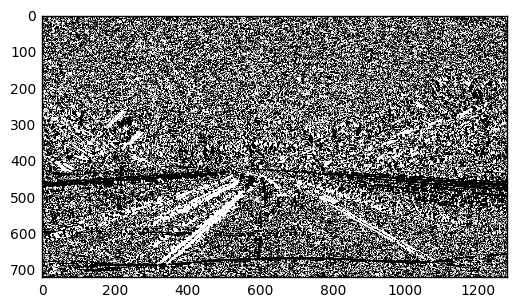

In [11]:
plt.imshow(dir_binary,cmap="gray")

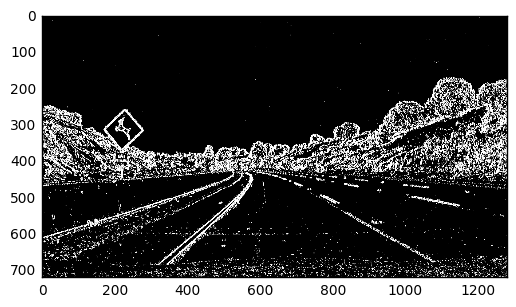

In [12]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    if(len(img.shape)>2):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8( 255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    
    #Return the masked image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
hls = cv2.cvtColor(highlight(image), cv2.COLOR_RGB2GRAY)
#Undistort 

gradx = abs_sobel_thresh(image, orient='x', thresh = [10,250])
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(100, 200))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(np.pi/1, np.pi/2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined,cmap="gray")

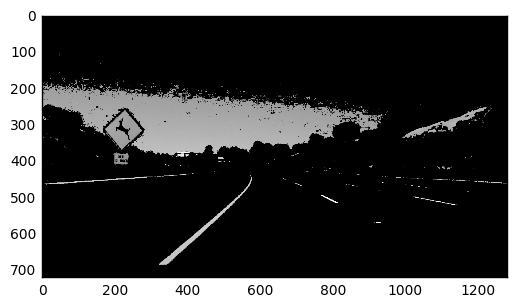

In [13]:
plt.imshow(hls,cmap="gray")

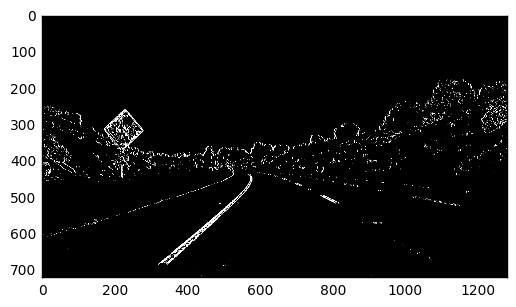

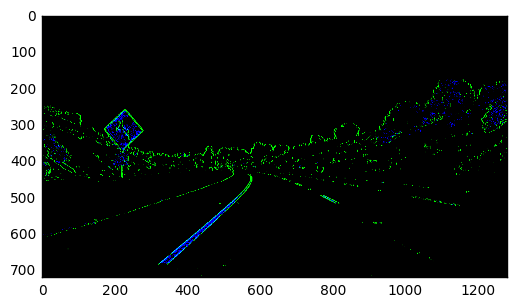

In [15]:
def color_gradient_threshold(image, s_thresh=(130, 255), sx_thresh=(45, 250)):
    img = np.copy(image)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    sobel_x_binary = abs_sobel_thresh(l_channel,'x',thresh=sx_thresh)
    
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.2))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (dir_binary == 1)] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sobel_x_binary), sobel_x_binary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_x_binary)
    combined_binary[((s_binary == 1) | (sobel_x_binary == 1))] = 1
    return combined_binary, color_binary

plt.imshow(color_gradient_threshold(image)[0],cmap="gray")
plt.show()
plt.imshow(color_gradient_threshold(image)[1])

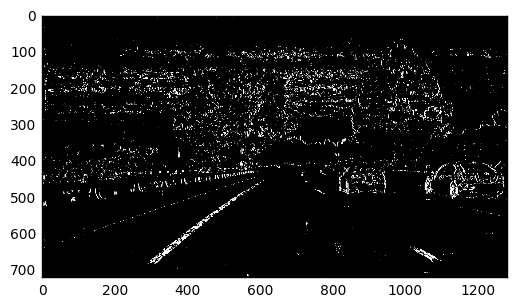

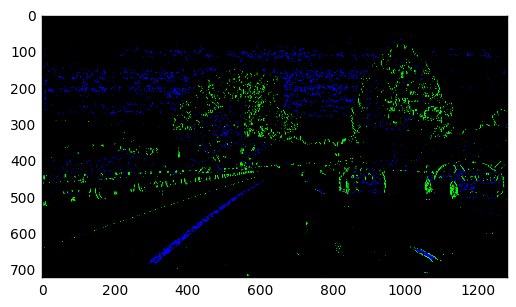

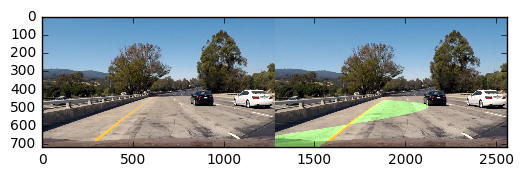

In [79]:
s_thresh=(130, 255)
sx_thresh=(45, 250)

left_fit_avg = []
right_fit_avg = []

_left_fit = None
_right_fit = None
        
def pipeline(img):
    global _left_fit
    global _right_fit
    orig = np.copy(img)
    ## Undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    gradient_image, colored_binary = color_gradient_threshold(img)
    binary_warped = warper(gradient_image, src, dst)
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_size = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_size
        win_y_high = binary_warped.shape[0] - window*window_size
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    alpha = 0.9
    if((_left_fit == None) and (_right_fit == None)):
        _left_fit = left_fit
        _right_fit = right_fit
    else:
        _left_fit = _left_fit*alpha+left_fit*(1-alpha)
        _right_fit = _right_fit*alpha + left_fit*(1-alpha)
    
    # Store fit coefficients
    left_fit_avg.append(left_fit)
    right_fit_avg.append(right_fit)
    
    left_fit = _left_fit
    right_fit = _right_fit

    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    yvals = fity
    image  = np.copy(img)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)
    y_eval = np.max(yvals)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(fity * ym_per_pix, fit_leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(fity * ym_per_pix, fit_rightx * xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')

    screen_middel_pixel = img.shape[1]/2
    left_lane_pixel = fit_leftx[-1]    # x position for left lane
    right_lane_pixel = fit_rightx[-1]   # x position for right lane
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = np.absolute(xm_per_pix * screen_off_center)
    
    result = np.hstack((orig,result))
    return result

img_test = mpimg.imread('../test_images/test1.jpg')
gradient_image, colored_binary = color_gradient_threshold(img_test)
src = np.float32([
    [585.0, 460.0],
    [203.0, 720.0],
    [1127, 720],
    [695, 460]
])

# dst = np.float32([
#     [270, 50],
#     [270, 670 ],
#     [910, 670 ],
#     [910, 50 ]
# ])
dst = np.float32([
    [320, 0],
    [320, 720 ],
    [960, 720 ],
    [960, 0 ]
])
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

# wpr = Warper(nx,ny,mtx,dist,src,dst)
# binary_warped = wpr.wrap(gradient_image)
gradient_image, colored_binary = color_gradient_threshold(img_test)

binary_warped = warper(gradient_image, src, dst)
plt.imshow(gradient_image,cmap="gray")
plt.show()
plt.imshow(colored_binary,cmap="gray")
plt.show()
plt.imshow(pipeline(img_test))

In [ ]:
left_fit_avg = []
right_fit_avg = []
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display
output = 'output.mp4'
clip1 = VideoFileClip("Second.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [72]:

class Pipeline():
    def __init__(self,src,dst,mxt,dist,alpha=0.9,debug=False):
        self._left_fit = None
        self._right_fit = None
        self.src = src
        self.dst = dst
        self.mtx = mtx
        self.dist = dist
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.inverse_M = cv2.getPerspectiveTransform(dst,src)
        self.alpha = alpha
        self.s_thresh=(130, 255)
        self.sobel_x_thresh=(45, 250)
        self.dir_thresh=(0.8, 1.2)
        self.debug = debug
        self.debug_array = []
        
        
    def _abs_sobel_thresh(self,img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        # Apply the following steps to img
        # 1) Convert to grayscale
        if(len(img.shape)>2):
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if(orient == 'x'):
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobel = np.absolute(sobel)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8( 255 * abs_sobel / np.max(abs_sobel))
        # 5) Create a mask of 1's where the scaled gradient magnitude 
                # is > thresh_min and < thresh_max
        # 6) Return this mask as your binary_output image
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        return binary_output
        
    def _dir_threshold(self,image, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Calculate gradient direction
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately


        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        # 3) Take the absolute value of the x and y gradients

        abs_sobel_x = np.absolute(sobel_x)
        abs_sobel_y = np.absolute(sobel_y)

        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        direction = np.arctan2(abs_sobel_y, abs_sobel_x)
        # 5) Create a binary mask where direction thresholds are met
        binary_output = np.zeros_like(direction)
        binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
        # 6) Return this mask as your binary_output image
        return binary_output



    def _color_gradient_threshold(self,image):
        img = np.copy(image)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]

        sobel_x_binary = self._abs_sobel_thresh(l_channel,'x',thresh=self.sobel_x_thresh)

        dir_binary = self._dir_threshold(img, sobel_kernel=15, thresh=self.dir_thresh)

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (dir_binary == 1)] = 1
        # Stack each channel
        color_binary = np.dstack(( np.zeros_like(sobel_x_binary), sobel_x_binary, s_binary))
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sobel_x_binary)
        combined_binary[((s_binary == 1) | (sobel_x_binary == 1))] = 1
        return combined_binary, color_binary
    
    def _warp(self,image):
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(image, self.M, img_size, flags=cv2.INTER_NEAREST) 
    
    # with exponential smoothing Exponential smoothing
    # https://en.wikipedia.org/wiki/Exponential_smoothing
    # alpha = 0.1
    def _fit(self,leftx,lefty,rightx,righty):
        
        # fit the polynomial to the points ..
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # for the first image no moving average
        if((self._left_fit == None) and (self._right_fit == None)):
            self._left_fit = left_fit
            self._right_fit = right_fit
        else:
            self._left_fit = self._left_fit*self.alpha+left_fit*(1-self.alpha)
            self._right_fit = self._right_fit*self.alpha + right_fit*(1-self.alpha)


        return self._left_fit,self._right_fit
    def _curvature(self,A,B,y):
        return (1+(2*A*y+B)**2)**(1.5)/(np.absolute(2*A))
    
    def process_image(self,img):
        orig = np.copy(img)
        
        self.debug_array = []
        self.debug_array.append(orig)
        ## Undistort the image
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        
        self.debug_array.append(np.copy(img))
        
        gradient_image,_ = self._color_gradient_threshold(img)
        binary_warped = self._warp(gradient_image)
        
        self.debug_array.append(cv2.cvtColor(np.copy(gradient_image),cv2.COLOR_GRAY2RGB))
        
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_size = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_size
            win_y_high = binary_warped.shape[0] - window*window_size
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        # Fit a second order polynomial to each
        
        ### fit the polynomial and moving average
        left_fit,right_fit = self._fit(leftx,lefty,rightx,righty)
    
        fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
        fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
        yvals = fity
        image  = np.copy(img)
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        Minv = cv2.getPerspectiveTransform(dst, src)
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([fit_leftx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, yvals])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        inverse_warp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(orig, 1, inverse_warp, 0.3, 0)
        y_eval = np.max(yvals)

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(fity * ym_per_pix, fit_leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(fity * ym_per_pix, fit_rightx * xm_per_pix, 2)

        # Calculate the new radii of curvature
        # 1+(2*Ay+B)/()
        left_curverad = self._curvature(left_fit_cr[0],left_fit_cr[1],y_eval*ym_per_pix )# ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = self._curvature(right_fit_cr[0],right_fit_cr[1],y_eval*ym_per_pix ) #((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # radius of curvature is in meters
        

        screen_middel_pixel = img.shape[1]/2
        left_lane_pixel = fit_leftx[-1]    # x position for left lane
        right_lane_pixel = fit_rightx[-1]   # x position for right lane
        car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
        screen_off_center = screen_middel_pixel-car_middle_pixel
        meters_off_center = np.absolute(xm_per_pix * screen_off_center)
        
        result_mask_image = np.zeros_like(result)
        
        
        
        mrg = 100
        cv2.rectangle(result, (mrg, 150), (img.shape[1]- mrg, 0),(52,73,94), -1)
        
        cv2.putText(result_mask_image, "Radius of Curvature left %d (m) , right %d (m)" %(int(left_curverad),int(right_curverad)) 
                    , (mrg+120,80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (61, 35, 71), 3)
        cv2.putText(result_mask_image, "Vehicle is %.2f left of center" % (meters_off_center) 
                    , (mrg+280,120), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (61, 35, 71), 3)
        
        
        result = cv2.addWeighted(result, 1, result_mask_image, 0.8, 0)
        if(self.debug):
            self.debug_array.append(result)
            result = np.hstack([cv2.resize(x,None,fx=0.2,fy=0.2) for x in  self.debug_array])
        else:
            result
        return result

In [77]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display
output = 'output_final.mp4'
clip1 = VideoFileClip("../project_video.mp4")
pipln = Pipeline(src,dst,mtx,dist,debug=False)
fn = pipln.process_image
output_clip = clip1.fl_image(fn) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

# onlyfiles = glob.glob("../test_images/*.jpg")
# for each in onlyfiles:
# #     pipln = Pipeline(src,dst)
# #     fn = pipln.process_image
#     image = plt.imread(each)
#     plt.imshow(fn(image))
#     plt.show()


[MoviePy] >>>> Building video output_final.mp4
[MoviePy] Writing video output_final.mp4


100%|█████████▉| 1260/1261 [06:37<00:00,  3.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_final.mp4 

CPU times: user 8min 5s, sys: 1min 32s, total: 9min 38s
Wall time: 6min 39s


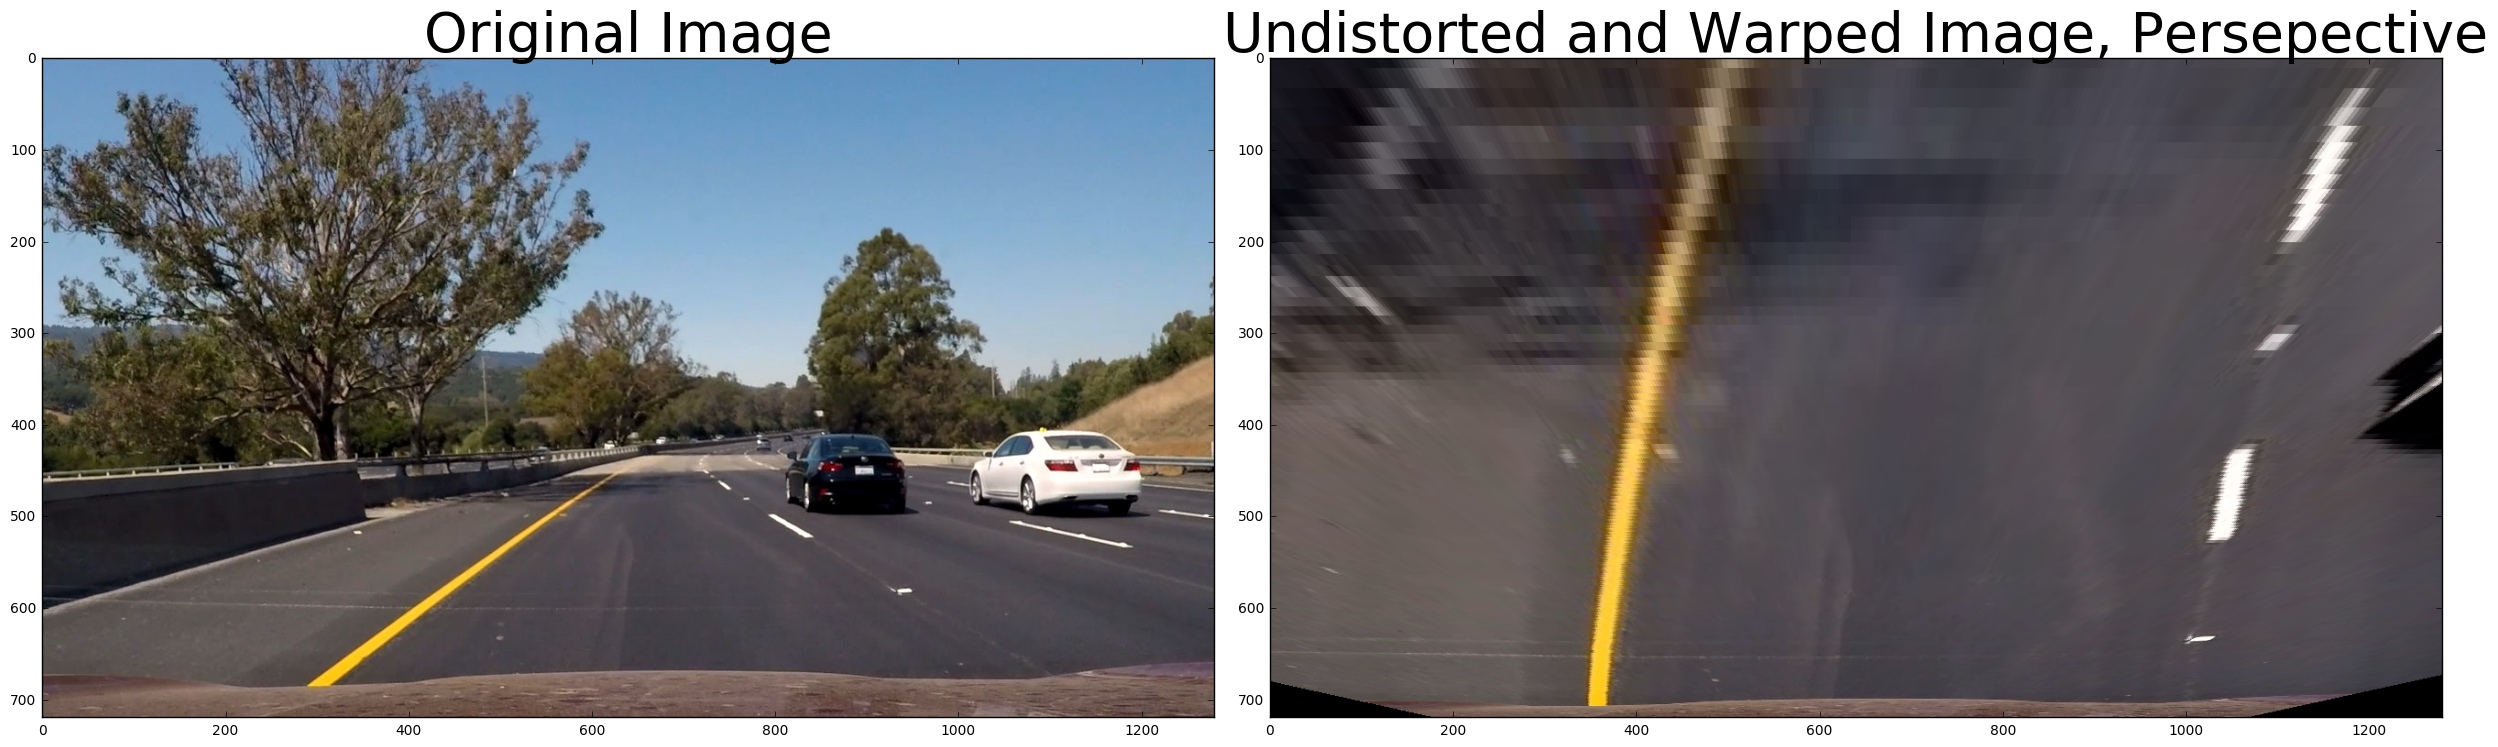

In [74]:

top_down = pipln._warp(image)

#top_down, perspective_M = corners_unwarp(img, nx, ny,mtx,dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image, Persepective', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



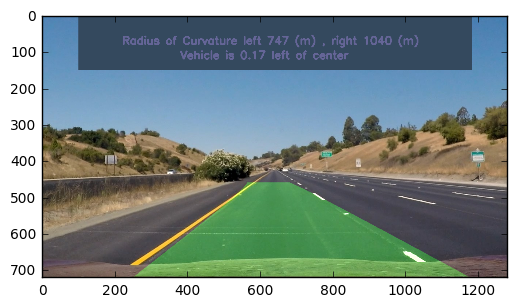

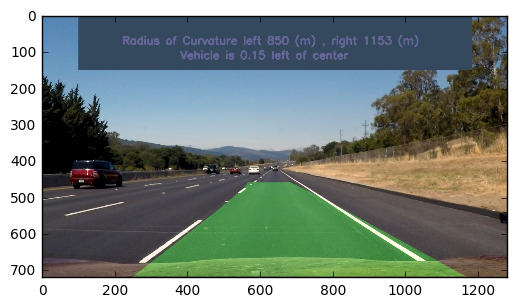

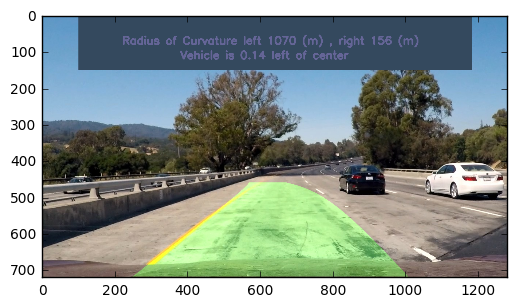

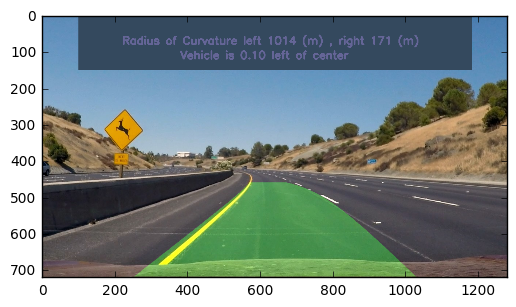

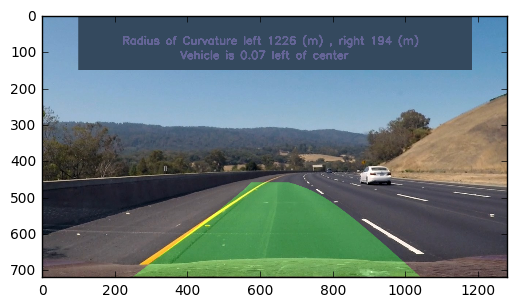

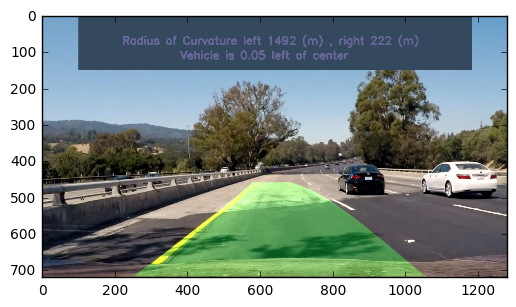

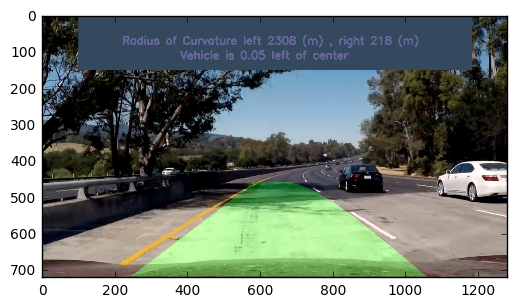

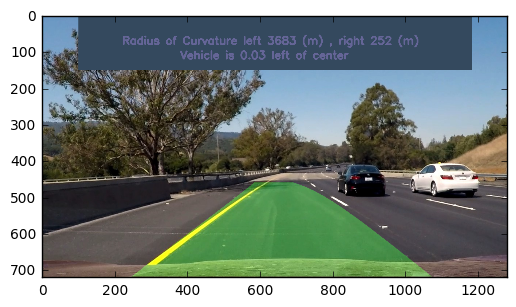

In [76]:
onlyfiles = glob.glob("../test_images/*.jpg")
for each in onlyfiles:
#     pipln = Pipeline(src,dst)
#     fn = pipln.process_image
    image = plt.imread(each)
    plt.imshow(fn(image))
    plt.show()
